In [1]:
%matplotlib inline
from matplotlib.colors import LogNorm, SymLogNorm
import numpy as np
import glob
import scipy
from astropy.io import fits
import matplotlib.pyplot as plt

from ctisim import ITL_AMP_GEOM
from ctisim.fitting import FullSimulatedModel, OverscanFitting

In [2]:
infile = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_results.fits'

hdulist = fits.open(infile)
max_signal = 160000.
read_noise = 7.2

amp = 7
start = 1
stop = 15

## Model params
ctiexp = np.log10(1.1E-6)
drift_scale = 0.0002
decay_time = 2.5
trapsize1 = 3.8
scaling = 0.08
trapsize2 = 38.0
f0 = 17700.
k = 0.001
emission_time = 0.4
params0 = (ctiexp, drift_scale, decay_time, trapsize1, scaling, trapsize2, f0, k, emission_time)

## Constraints
constraints = [(np.log10(8.E-7), np.log10(3.E-6)),
               (0.00015, 0.00025),
               (2.3, 2.6),
               (0.0, 5.0),
               (0.05, 0.1),
               (35.0, 45.0),
               (16000., 18000.),
               (0.0007, 0.0013),
               (0.35, 0.5)]

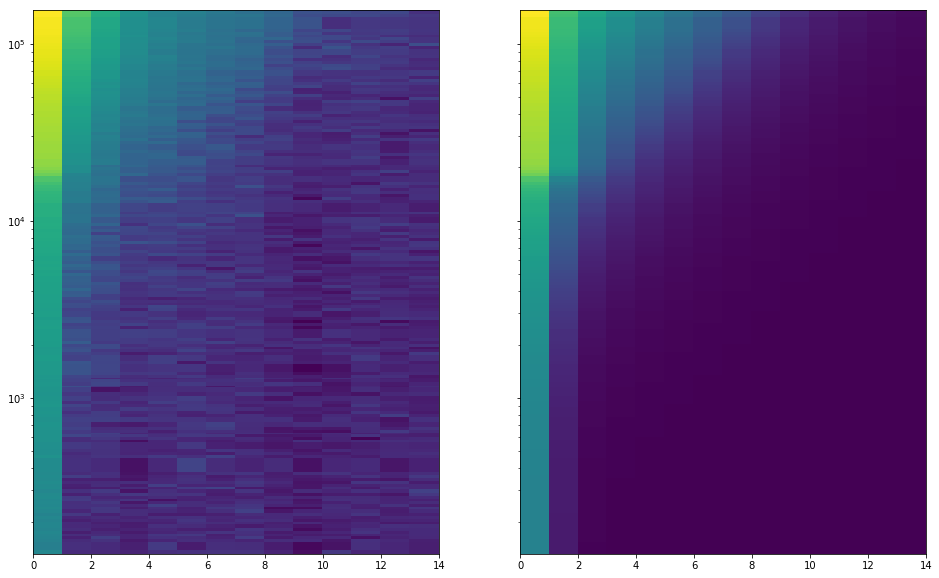

In [3]:
## Signals
all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]

## Data
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

## Model
fitting_model = FullSimulatedModel(params0, ITL_AMP_GEOM)
model = fitting_model.results(signals, start=start, stop=stop)

y=signals
x=np.arange(model.shape[1])
X,Y=np.meshgrid(x, y)

fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=True)

im0 = axes[0].pcolor(X,Y,data, norm=SymLogNorm(1.0))
im1 = axes[1].pcolor(X,Y,model, norm=SymLogNorm(1.0))
axes[0].set_yscale('log')
axes[1].set_yscale('log')

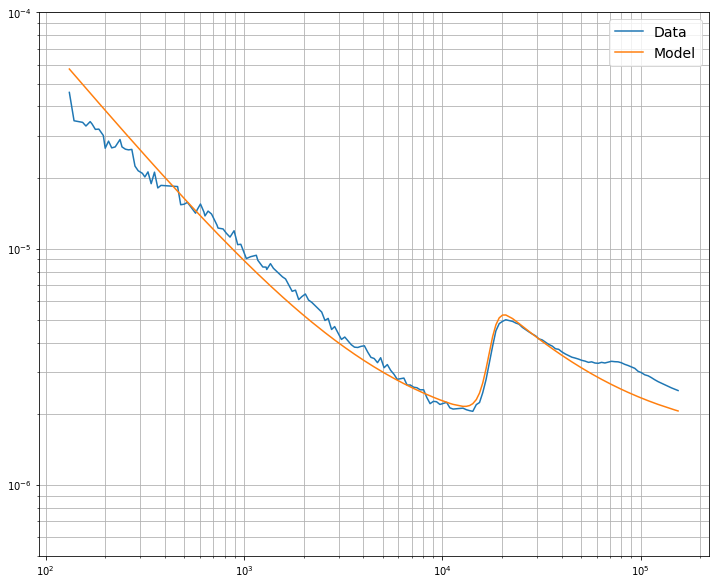

In [4]:
cti_data = np.sum(data[:, :2], axis=1)/(512*signals)
cti_model = np.sum(model[:, :2], axis=1)/(512*signals)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(signals, cti_data, label='Data')
ax.plot(signals, cti_model, label='Model')
ax.legend(fontsize=14)
ax.set_yscale('log')
ax.set_ylim(5E-7, 1E-4)
ax.set_xscale('log')
ax.grid(which='both', axis='both')

In [13]:
fit_task = OverscanFitting(params0, constraints, FullSimulatedModel, start=start, stop=stop)

error = 7.2/np.sqrt(2000.)
fit_task.rms_error(params0, signals, data, read_noise/np.sqrt(2000.), ITL_AMP_GEOM)

2.8612484294548786

In [17]:
res = scipy.optimize.minimize(fit_task.rms_error,
                            params0,
                            args=(signals, data, read_noise/np.sqrt(2000.), ITL_AMP_GEOM),
                            bounds=constraints, method='SLSQP')

params_new = res.x


## Testing Electronic Effect Correction

In [27]:
from ctisim import SegmentSimulator, FloatingOutputAmplifier, ITL_AMP_GEOM
from ctisim.matrix import electronics_operator
from ctisim import LogisticTrap, LinearTrap

trap0 = LinearTrap(4.0, 0.4, 1, 0.08)
trap1 = LogisticTrap(40.0, 0.4, 1, 17500, 0.001)
traps = [trap0, trap1]
traps = None

In [28]:
cti = 1.E-6

scale = 0.0002
decay_time = 2.4
output_amplifier = FloatingOutputAmplifier(1.0, scale, decay_time)

signals = np.logspace(1, np.log10(175000.), 200)
#signals = np.linspace(100, 175000., 100)
imarr = np.zeros((signals.shape[0], ITL_AMP_GEOM.nx))

## Simulate ramp readout
ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, cti=cti, traps=traps)
ramp.ramp_exp(signals)
model_results = ramp.readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                             parallel_overscan_width=0)

print(model_results.shape)

(200, 576)


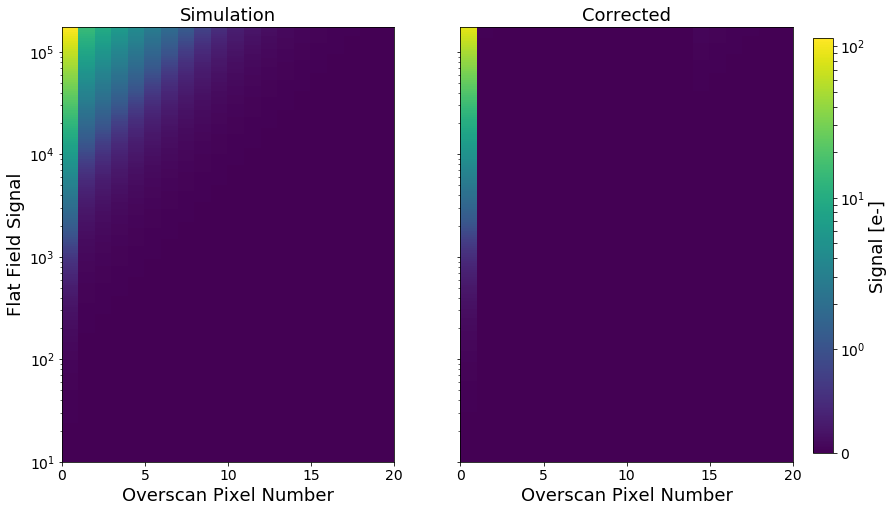

In [51]:
E = electronics_operator(model_results, scale, decay_time, num_previous_pixels=15)

start = ITL_AMP_GEOM.nx+ITL_AMP_GEOM.prescan_width
stop = start+21

original = model_results[:, start:stop]
corrected = (model_results-E)[:, start:stop]

vmin = 0.0
vmax = np.max(original)

y=signals
x=np.arange(original.shape[1])
X,Y=np.meshgrid(x, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
im0 = axes[0].pcolor(X, Y, original, 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
im1 = axes[1].pcolor(X, Y, corrected, 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
axes[0].set_yscale('log')
axes[0].set_ylabel('Flat Field Signal', fontsize=18)
axes[0].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_title('Simulation', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[1].set_title('Corrected', fontsize=18)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.14, 0.02, 0.72])
cbar= fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Signal [e-]', fontsize=18)
cbar.ax.tick_params(labelsize=14) 

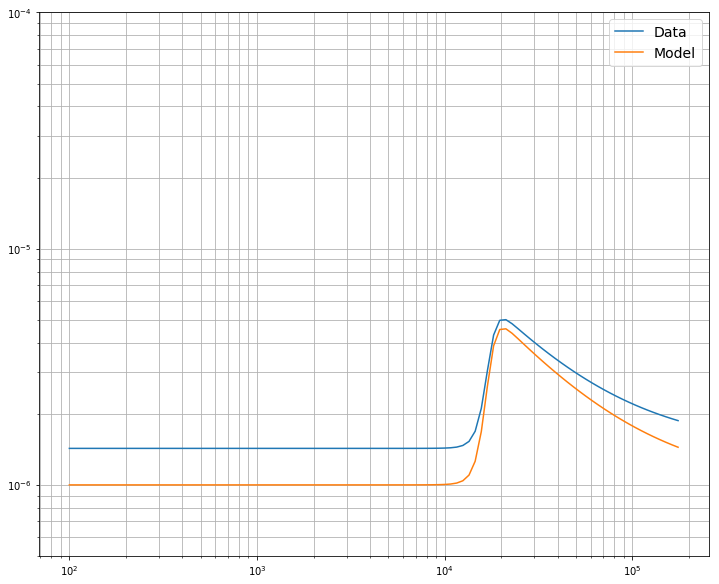

In [92]:
cti_original = np.sum(original[:, :2], axis=1)/(512*signals)
cti_corrected = np.sum(corrected[:, :2], axis=1)/(512*signals)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(signals, cti_original, label='Data')
ax.plot(signals, cti_corrected, label='Model')
ax.legend(fontsize=14)
ax.set_yscale('log')
ax.set_ylim(5E-7, 1E-4)
ax.set_xscale('log')
ax.grid(which='both', axis='both')

In [50]:
2.4*2*1/(500.*2000.)

4.8e-06